<a href="https://colab.research.google.com/github/Khadijakhanbme/EEG-Emotion-Analysis-Deap-Dataset/blob/main/DEAP_DATASET_SIGNAL_PROCESSING_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Dataset Description**

This project uses the DEAP (Database for Emotion Analysis using Physiological Signals) dataset, which is organized into subject-wise MATLAB (.mat) files, where each file corresponds to one participant.The received folder contains data from 20 subjects.

Each subject file contains two main variables:

**data:** a three-dimensional array of size (40 × 40 × 8064), representing


*   40 trials (video stimuli)
*   40 recorded physiological channels
*   8064 time samples per channel per trial

**labels:** a matrix of size (40 × 4), containing emotion ratings for each trial on a 1–9 scale, corresponding to Valence, Arousal, Dominance, and Liking.

*According to the official DEAP dataset documentation*, the 40 recorded channels include *32 EEG channels and 8 peripheral physiological channels*.

**In this study, only the EEG recordings (32 channels) were considered, and the emotion analysis focused on the Valence and Arousal dimensions of 10 subjects, as required by the project.**

**Installations**

Import required libraries for data loading, numerical processing, signal analysis, wavelet feature extraction, and visualization.


In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
!pip -q install PyWavelets
import pywt
from scipy.io import loadmat
from google.colab import drive


**Drive Mount**

Mount Google Drive to access the DEAP dataset stored there.


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


**Path and File Check**

Defined the path to the DEAP dataset and list subject-wise .mat files.

Only the first N_SUBJECTS (10) files are selected for analysis.


In [3]:
DATA_PATH = r"/content/drive/MyDrive/DEAP_DATASET"

# List files
N_SUBJECTS = 10
files = sorted([f for f in os.listdir(DATA_PATH) if f.endswith(".mat")])
print("Total .mat files found:", len(files))
print("Files to process:", files[:N_SUBJECTS])


Total .mat files found: 20
Files to process: ['s01.mat', 's02.mat', 's03.mat', 's04.mat', 's05.mat', 's06.mat', 's07.mat', 's08.mat', 's09.mat', 's10.mat']


**Data Pre-processing**

In [4]:
#Definition of dataset related Parameters

EEG_CHANNELS = 32
FS = 128
BASELINE_SEC = 3 #(From DEAP Documentation)
BASELINE_SAMPLES = FS * BASELINE_SEC  # 128*3=384

# Reset each time, running pre-processing
eeg_all = []
valence_all = []
arousal_all = []

for fname in files[:N_SUBJECTS]:
    full_path = os.path.join(DATA_PATH, fname)
    mat = loadmat(full_path)

    data = mat["data"]      # (40, 40, 8064)
    labels = mat["labels"]  # (40, 4)

    # 1) Keep EEG channels only
    eeg = data[:, :EEG_CHANNELS, :]              # (40, 32, 8064)

    # 2) Remove first 3 seconds baseline
    eeg_trim = eeg[:, :, BASELINE_SAMPLES:]      # (40, 32, 7680)

    # 3) Keep continuous emotions (valence + arousal)
    valence = labels[:, 0].astype(np.float32)    # (40,)
    arousal = labels[:, 1].astype(np.float32)    # (40,)

    eeg_all.append(eeg_trim.astype(np.float32))
    valence_all.append(valence)
    arousal_all.append(arousal)

    print(f"[OK] {fname} -> eeg_trim: {eeg_trim.shape}")

# Convert lists to NumPy arrays for efficient numerical processing

eeg_all = np.array(eeg_all)           # (10, 40, 32, 7680)
valence_all = np.array(valence_all)   # (10, 40)
arousal_all = np.array(arousal_all)   # (10, 40)

[OK] s01.mat -> eeg_trim: (40, 32, 7680)
[OK] s02.mat -> eeg_trim: (40, 32, 7680)
[OK] s03.mat -> eeg_trim: (40, 32, 7680)
[OK] s04.mat -> eeg_trim: (40, 32, 7680)
[OK] s05.mat -> eeg_trim: (40, 32, 7680)
[OK] s06.mat -> eeg_trim: (40, 32, 7680)
[OK] s07.mat -> eeg_trim: (40, 32, 7680)
[OK] s08.mat -> eeg_trim: (40, 32, 7680)
[OK] s09.mat -> eeg_trim: (40, 32, 7680)
[OK] s10.mat -> eeg_trim: (40, 32, 7680)


**Quality Checks**

Data integrity is verified by checking shapes, label ranges, signal values, and absence of NaN or infinite values.


In [5]:
print("\n ---------FINAL SHAPE CHECK ----------    ")
print("EEG (subjects, trials, channels, samples):", eeg_all.shape)
print("Valence (subjects, trials):", valence_all.shape)
print("Arousal (subjects, trials):", arousal_all.shape)

print("\n----------LABEL RANGE CHECK (should be 1..9) -----------   ")
print("Valence min/max:", float(valence_all.min()), float(valence_all.max()))
print("Arousal min/max:", float(arousal_all.min()), float(arousal_all.max()))

print("\n------------SIGNAL RANGE CHECK (sanity only) -----------")
print("EEG min/max:", float(eeg_all.min()), float(eeg_all.max()))

print("\n----------NAN/INF CHECK---------------")
print("EEG contains NaN:", bool(np.isnan(eeg_all).any()))
print("EEG contains Inf:", bool(np.isinf(eeg_all).any()))
print("Valence contains NaN:", bool(np.isnan(valence_all).any()))
print("Arousal contains NaN:", bool(np.isnan(arousal_all).any()))



 ---------FINAL SHAPE CHECK ----------    
EEG (subjects, trials, channels, samples): (10, 40, 32, 7680)
Valence (subjects, trials): (10, 40)
Arousal (subjects, trials): (10, 40)

----------LABEL RANGE CHECK (should be 1..9) -----------   
Valence min/max: 1.0 9.0
Arousal min/max: 1.0 9.0

------------SIGNAL RANGE CHECK (sanity only) -----------
EEG min/max: -1601.9666748046875 1551.6575927734375

----------NAN/INF CHECK---------------
EEG contains NaN: False
EEG contains Inf: False
Valence contains NaN: False
Arousal contains NaN: False


**Multi-channel EEG snapshot for Visualization**

Representative EEG signals from four channels (Ch0, Ch10, Ch20, Ch30), covering frontal to occipital regions, are shown for a single subject and trial to illustrate temporal and spatial variability.

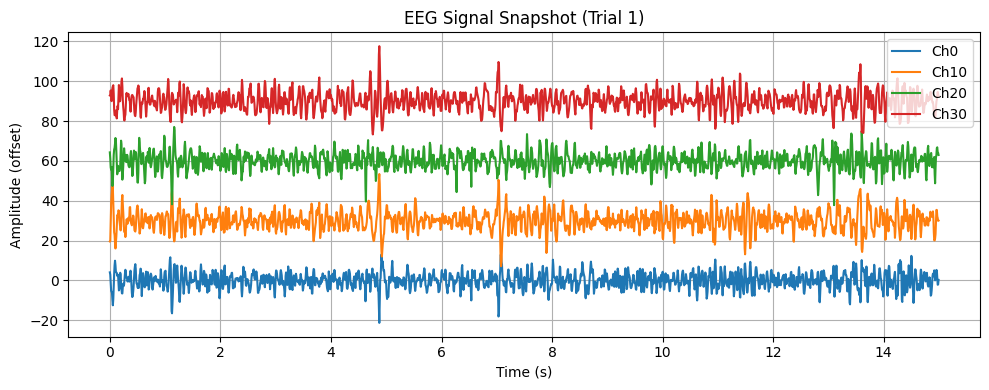

In [6]:
channels = [0, 10, 20, 30]  # example channels
duration = 15
Trial=0
n_samples = FS * duration
time = np.arange(n_samples) / FS

plt.figure(figsize=(10, 4))

for i, ch in enumerate(channels):
    sig = eeg_all[0, Trial, ch, :n_samples]
    plt.plot(time, sig + i*30, label=f"Ch{ch}")  # offset

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (offset)")
plt.title("EEG Signal Snapshot (Trial 1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Power spectral density**


PSD of one representative channel is presented to verify the frequency content of the EEG signals.

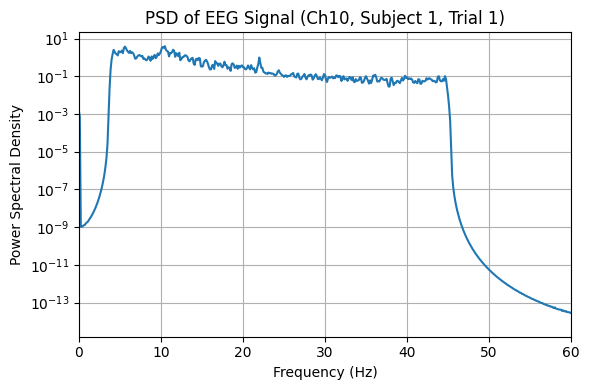

In [7]:
# PSD of representative EEG channel (Ch10)

ch_psd = 10  # P3
signal = eeg_all[0, Trial, ch_psd, :]

from scipy.signal import welch
f, psd = welch(signal, fs=FS, nperseg=1024)

plt.figure(figsize=(6,4))
plt.semilogy(f, psd)
plt.xlim(0, 60)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("PSD of EEG Signal (Ch10, Subject 1, Trial 1)")
plt.grid(True)
plt.tight_layout()
plt.show()


According to the official DEAP dataset documentation, **the EEG signals are already preprocessed**, including band-pass filtering, artifact removal, and downsampling to 128 Hz. This preprocessing was further verified by visual inspection and power spectral density (PSD) analysis, which confirmed that the signal energy is concentrated below 45 Hz with no prominent high-frequency noise. Therefore, **no additional preprocessing was applied**, and the analysis directly **proceeded to wavelet-based feature extraction**.

**Chosen Wavlet Transform Method** : Discrete Wavelet Transform (DWT)

Although alternative time–frequency methods such as Fourier-based analysis, Continuous Wavelet Transform (CWT), and Wavelet Packet Transform (WPT) exist;  DWT was chosen due to its computational efficiency, interpretability, and widespread use in EEG emotion analysis.

**Wavelet settings**

Discrete Wavelet Transform (DWT) was used to extract multi-resolution spectral features from EEG signals. The Daubechies-4 (db4) wavelet was selected due to its good time–frequency localization. A 5-level decomposition was applied, which is appropriate for EEG signals sampled at 128 Hz, allowing the signal to be decomposed into sub-bands covering low- to mid-frequency EEG components. This choice is supported by the observed PSD (above), which shows that most EEG energy lies below 40 Hz.

In [8]:
WAVELET = "db4"
LEVEL = 5    # good for EEG bands at 128 Hz
FS = 128

**Channel Wise Analysis**

In channel-wise analysis, wavelet sub-band energy features were extracted independently for each of the 32 EEG channels using Discrete Wavelet Transform. For each channel, correlations between band-specific energies and emotional dimensions (valence and arousal) were computed across trials. This analysis enables identification of EEG channels that are more sensitive to emotional variations, providing a detailed spatial characterization of emotion-related EEG activity.

In [9]:
def dwt_band_energies_1d(x, wavelet="db4", level=5):
    """
    Returns energies for [A_level, D_level, D_level-1, ..., D1]
    in a fixed order list + band labels.
    """
    coeffs = pywt.wavedec(x, wavelet, level=level)

    bands = [f"A{level}"] + [f"D{j}" for j in range(level, 0, -1)]
    energies = [np.sum(np.square(coeffs[0]))]  # A_level

    # Details: coeffs[1:] are [D_level, ..., D1]
    for cD in coeffs[1:]:
        energies.append(np.sum(np.square(cD)))

    return np.array(energies, dtype=np.float32), bands

def safe_corr(x, y):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    if np.std(x) < 1e-12 or np.std(y) < 1e-12:
        return np.nan
    return float(np.corrcoef(x, y)[0, 1])


**Compute DWT energies for every channel per trial**


In [10]:
n_subj, n_trials, n_ch, n_samp = eeg_all.shape

# Compute band labels once
tmp_energy, band_labels = dwt_band_energies_1d(eeg_all[0,0,0,:], wavelet=WAVELET, level=LEVEL)
n_bands = len(tmp_energy)

feat_energy = np.zeros((n_subj, n_trials, n_ch, n_bands), dtype=np.float32)

for s in range(n_subj):
    for t in range(n_trials):
        for ch in range(n_ch):
            e, _ = dwt_band_energies_1d(eeg_all[s, t, ch, :], wavelet=WAVELET, level=LEVEL)
            feat_energy[s, t, ch, :] = e

print("feat_energy shape (subj, trials, ch, bands):", feat_energy.shape)
print("Bands:", band_labels)


feat_energy shape (subj, trials, ch, bands): (10, 40, 32, 6)
Bands: ['A5', 'D5', 'D4', 'D3', 'D2', 'D1']


**Channel-wise correlation with Valence and Arousal**

Computed correlation between EEG features and emotions for each channel and wavelet band separately.

In [11]:
corr_val_chband = np.zeros((n_subj, n_ch, n_bands), dtype=np.float32)
corr_aro_chband = np.zeros((n_subj, n_ch, n_bands), dtype=np.float32)

for s in range(n_subj):
    yv = valence_all[s, :]
    ya = arousal_all[s, :]
    for ch in range(n_ch):
        for b in range(n_bands):
            x = feat_energy[s, :, ch, b]  # 40 trials
            corr_val_chband[s, ch, b] = safe_corr(x, yv)
            corr_aro_chband[s, ch, b] = safe_corr(x, ya)

print("corr_val_chband:", corr_val_chband.shape)
print("corr_aro_chband:", corr_aro_chband.shape)


corr_val_chband: (10, 32, 6)
corr_aro_chband: (10, 32, 6)


**Group-average heatmaps (Channels × Bands)**

Visualize spatial distribution of emotion-related EEG features using channel-by-band correlation heatmaps.
Each correlation was computed using trial-wise variability across the 40 video stimuli.

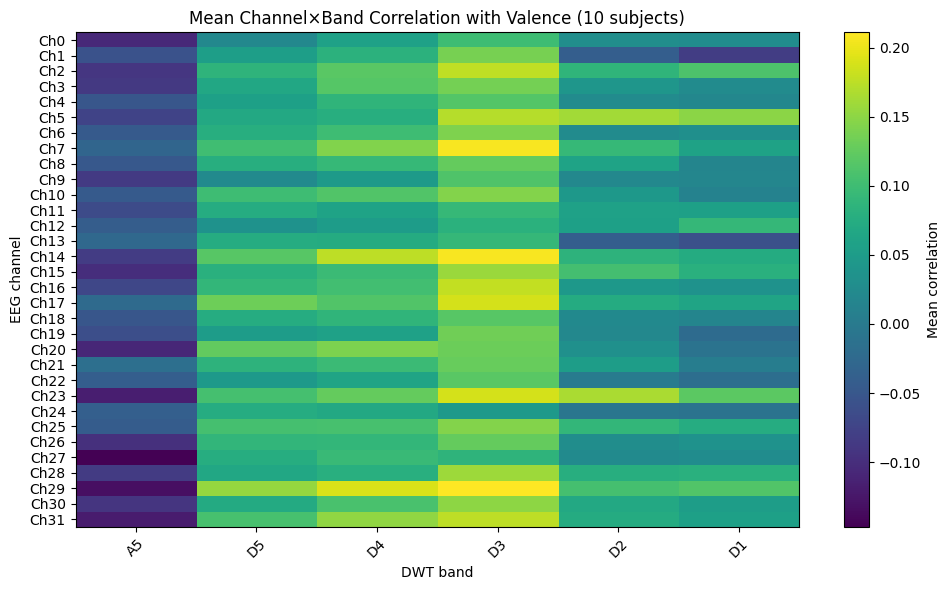

In [12]:
mean_corr_val = np.nanmean(corr_val_chband, axis=0)  # (channels, bands)
mean_corr_aro = np.nanmean(corr_aro_chband, axis=0)  # (channels, bands)

# Heatmap: Valence
plt.figure(figsize=(10, 6))
plt.imshow(mean_corr_val, aspect="auto")
plt.colorbar(label="Mean correlation")
plt.xticks(np.arange(n_bands), band_labels, rotation=45)
plt.yticks(np.arange(n_ch), [f"Ch{c}" for c in range(n_ch)])
plt.title("Mean Channel×Band Correlation with Valence (10 subjects)")
plt.xlabel("DWT band")
plt.ylabel("EEG channel")
plt.tight_layout()
plt.show()


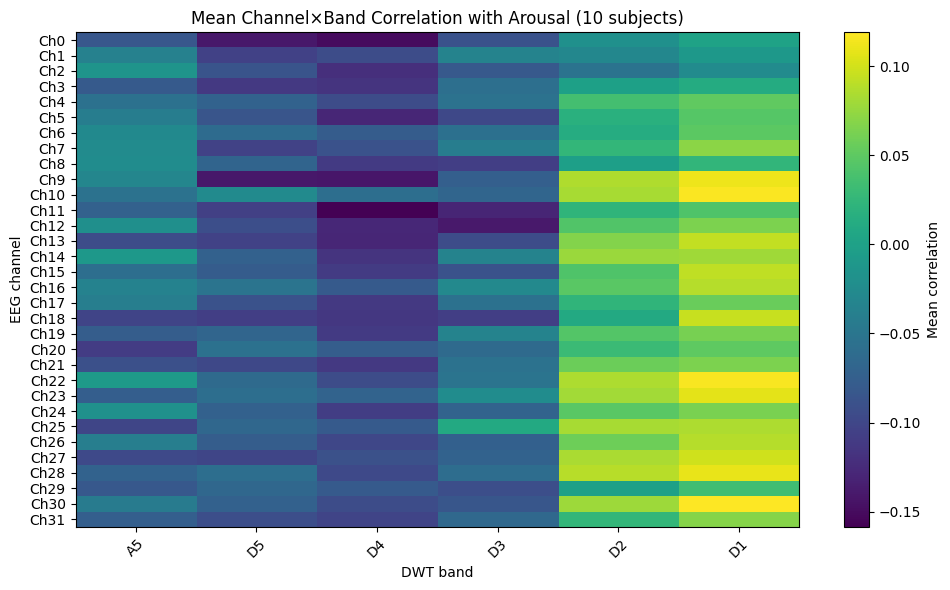

In [13]:
# Heatmap: Arousal
plt.figure(figsize=(10, 6))
plt.imshow(mean_corr_aro, aspect="auto")
plt.colorbar(label="Mean correlation")
plt.xticks(np.arange(n_bands), band_labels, rotation=45)
plt.yticks(np.arange(n_ch), [f"Ch{c}" for c in range(n_ch)])
plt.title("Mean Channel×Band Correlation with Arousal (10 subjects)")
plt.xlabel("DWT band")
plt.ylabel("EEG channel")
plt.tight_layout()
plt.show()

**Top channels (most emotion-informative)**


In [14]:
# Score each channel by max abs correlation across bands
score_val = np.nanmax(np.abs(mean_corr_val), axis=1)  # (channels,)
score_aro = np.nanmax(np.abs(mean_corr_aro), axis=1)  # (channels,)

top_k = 10
top_val_idx = np.argsort(score_val)[::-1][:top_k]
top_aro_idx = np.argsort(score_aro)[::-1][:top_k]

print("Top channels for Valence (by max |corr|):", top_val_idx)
print("Scores:", score_val[top_val_idx])

print("\nTop channels for Arousal (by max |corr|):", top_aro_idx)
print("Scores:", score_aro[top_aro_idx])


Top channels for Valence (by max |corr|): [29  7 14 17 23 16  2 31  5 28]
Scores: [0.21109506 0.20733401 0.20693815 0.18805447 0.18752532 0.1778294
 0.17705664 0.17586236 0.17125334 0.1588907 ]

Top channels for Arousal (by max |corr|): [11  0  9 12 13  5  2 30 14 10]
Scores: [0.15858167 0.15098195 0.14139338 0.13951834 0.1291363  0.12857479
 0.12117618 0.11889589 0.11699545 0.11687195]


**Bar plots for Top-10 channels**

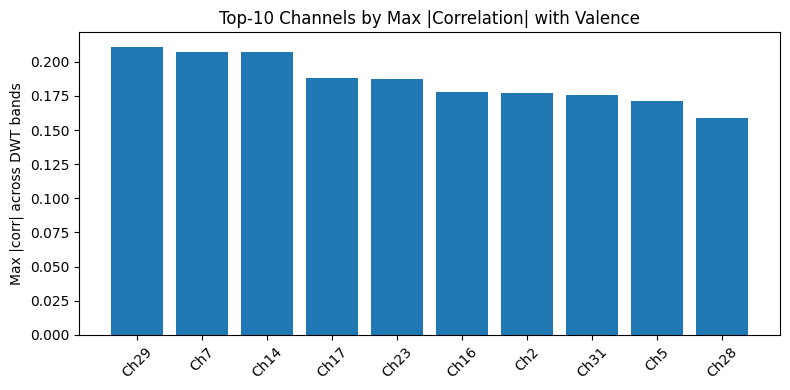

In [15]:
# Valence top channels bar plot
plt.figure(figsize=(8,4))
plt.bar([f"Ch{i}" for i in top_val_idx], score_val[top_val_idx])
plt.title("Top-10 Channels by Max |Correlation| with Valence")
plt.ylabel("Max |corr| across DWT bands")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



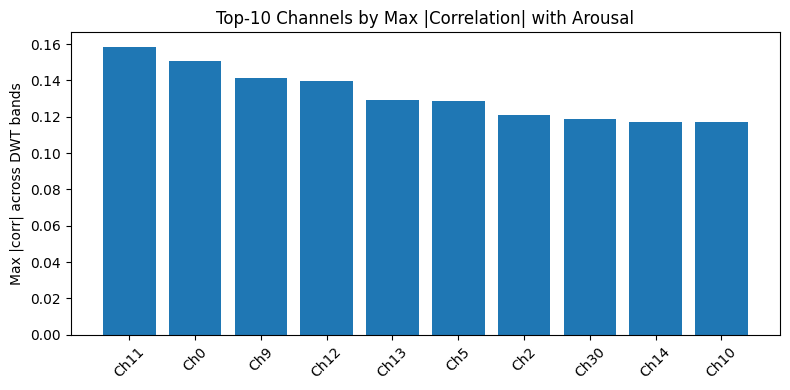

In [16]:
# Arousal top channels bar plot
plt.figure(figsize=(8,4))
plt.bar([f"Ch{i}" for i in top_aro_idx], score_aro[top_aro_idx])
plt.title("Top-10 Channels by Max |Correlation| with Arousal")
plt.ylabel("Max |corr| across DWT bands")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation from Channel Wise Analysis:**

The channel-wise analysis highlights that emotional information is not uniformly distributed across EEG channels.


For **valence**, stronger correlations are concentrated in a limited subset of channels, particularly within the mid-level wavelet sub-bands D3 and D4. Channels such as Ch29, Ch7, Ch14, Ch17, Ch23, and Ch16 exhibit the highest maximum correlations, indicating that valence-related neural activity is captured more prominently by specific EEG channels rather than across the entire scalp. In contrast, the lowest-frequency approximation band (A5) shows weak or negative correlations across most channels, suggesting limited relevance of very slow EEG components for valence estimation.


For **arousal**, the correlation patterns differ notably. While lower and mid-frequency bands (A5–D3) generally show weak or negative correlations, higher-frequency bands (D2 and D1) demonstrate consistently positive correlations across a broader set of channels. Channels such as Ch11, Ch0, Ch9, Ch12, and Ch13 show the strongest associations with arousal, reflecting a more distributed channel involvement compared to valence. This indicates that arousal-related EEG activity is captured across multiple channels and is more strongly linked to higher-frequency components.

Overall, the channel-wise results suggest that **valence is characterized by selective channel sensitivity in mid-frequency wavelet bands**, whereas **arousal exhibits broader channel involvement with stronger contributions from higher-frequency bands**.


These findings motivate further aggregation and interpretation of the results through region-wise and band-wise analyses.

**Region Wise Analysis**



In [17]:
# =======================
# DEAP EEG CHANNEL ORDER
# =======================
DEAP_EEG_CH_NAMES = [
    "Fp1","AF3","F3","F7","FC5","FC1","C3","T7",
    "CP5","CP1","P3","P7","PO3","O1","Oz","Pz",
    "Fp2","AF4","Fz","F4","F8","FC6","FC2","Cz",
    "C4","T8","CP6","CP2","P4","P8","PO4","O2"
]

CH_NAME_TO_IDX = {ch: i for i, ch in enumerate(DEAP_EEG_CH_NAMES)}

# =======================
# REGION DEFINITIONS
# =======================
REGIONS = {
    "Frontal": ["Fp1","Fp2","AF3","AF4","F3","F4","F7","F8","Fz"],
    "FrontoCentral": ["FC5","FC6","FC1","FC2"],
    "Central": ["C3","C4","Cz"],
    "Temporal": ["T7","T8"],
    "Parietal": ["CP5","CP6","CP1","CP2","P3","P4","P7","P8","Pz"],
    "Occipital": ["PO3","PO4","O1","O2","Oz"]
}

REGION_IDXS = {
    region: [CH_NAME_TO_IDX[ch] for ch in ch_list]
    for region, ch_list in REGIONS.items()
}

# =======================
# REGION-WISE CORRELATION
# =======================
n_subj, _, _, n_bands = feat_energy.shape

region_corr_val = {}
region_corr_aro = {}

for region, idxs in REGION_IDXS.items():

    # Average DWT energies across channels in region
    region_feat = feat_energy[:, :, idxs, :].mean(axis=2)
    # shape: (subjects, trials, bands)

    corr_v = np.zeros((n_subj, n_bands))
    corr_a = np.zeros((n_subj, n_bands))

    for s in range(n_subj):
        for b in range(n_bands):
            corr_v[s, b] = safe_corr(region_feat[s, :, b], valence_all[s, :])
            corr_a[s, b] = safe_corr(region_feat[s, :, b], arousal_all[s, :])

    region_corr_val[region] = (np.nanmean(corr_v, axis=0),
                               np.nanstd(corr_v, axis=0))
    region_corr_aro[region] = (np.nanmean(corr_a, axis=0),
                               np.nanstd(corr_a, axis=0))

# =======================
# PRINT SUMMARY TABLE
# =======================
print("\n===== REGION-WISE SENSITIVITY (Mean ± Std across 10 subjects) =====")

for region in REGIONS:
    mv, sv = region_corr_val[region]
    ma, sa = region_corr_aro[region]

    print(f"\n{region}")
    for i, band in enumerate(band_labels):
        print(f"  {band}: "
              f"Valence {mv[i]: .3f} ± {sv[i]:.3f} | "
              f"Arousal {ma[i]: .3f} ± {sa[i]:.3f}")



===== REGION-WISE SENSITIVITY (Mean ± Std across 10 subjects) =====

Frontal
  A5: Valence -0.072 ± 0.119 | Arousal -0.048 ± 0.227
  D5: Valence  0.071 ± 0.117 | Arousal -0.095 ± 0.190
  D4: Valence  0.084 ± 0.123 | Arousal -0.116 ± 0.172
  D3: Valence  0.164 ± 0.162 | Arousal -0.055 ± 0.147
  D2: Valence  0.040 ± 0.222 | Arousal  0.020 ± 0.169
  D1: Valence  0.026 ± 0.233 | Arousal  0.045 ± 0.180

FrontoCentral
  A5: Valence -0.061 ± 0.141 | Arousal -0.022 ± 0.191
  D5: Valence  0.040 ± 0.109 | Arousal -0.096 ± 0.205
  D4: Valence  0.043 ± 0.105 | Arousal -0.136 ± 0.194
  D3: Valence  0.123 ± 0.098 | Arousal -0.079 ± 0.187
  D2: Valence  0.048 ± 0.200 | Arousal  0.048 ± 0.190
  D1: Valence  0.028 ± 0.201 | Arousal  0.070 ± 0.199

Central
  A5: Valence -0.049 ± 0.077 | Arousal -0.011 ± 0.208
  D5: Valence  0.088 ± 0.143 | Arousal -0.068 ± 0.188
  D4: Valence  0.094 ± 0.141 | Arousal -0.091 ± 0.172
  D3: Valence  0.132 ± 0.148 | Arousal -0.067 ± 0.180
  D2: Valence  0.078 ± 0.219 | Aro

The table summarizes the **mean and variability of correlations between regional wavelet sub-band energies and emotional dimensions across subjects**. For valence, the D3 band consistently exhibits the highest positive correlations across regions, while the approximation band A5 shows weak or negative associations. In contrast, arousal correlations are relatively low in mid-frequency bands and increase toward higher-frequency bands (D2–D1), with greater inter-subject variability.

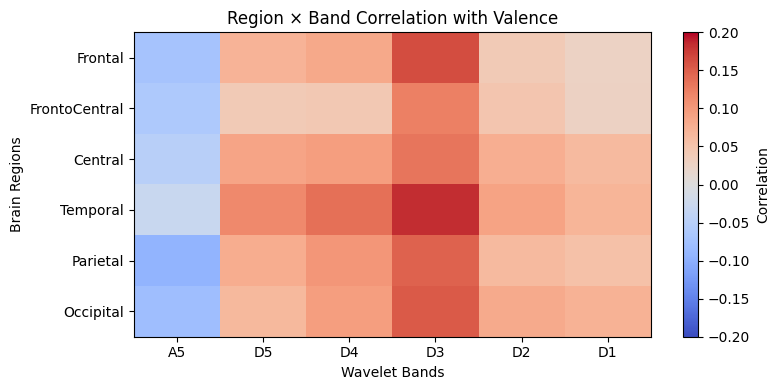

In [18]:
import matplotlib.pyplot as plt
import numpy as np

regions = list(region_corr_val.keys())
bands = band_labels

# Build matrices: (regions x bands)
val_mat = np.array([region_corr_val[r][0] for r in regions])
aro_mat = np.array([region_corr_aro[r][0] for r in regions])

# ---- Valence heatmap ----
plt.figure(figsize=(8, 4))
plt.imshow(val_mat, aspect="auto", cmap="coolwarm", vmin=-0.2, vmax=0.2)
plt.colorbar(label="Correlation")
plt.xticks(range(len(bands)), bands)
plt.yticks(range(len(regions)), regions)
plt.title("Region × Band Correlation with Valence")
plt.xlabel("Wavelet Bands")
plt.ylabel("Brain Regions")
plt.tight_layout()
plt.show()



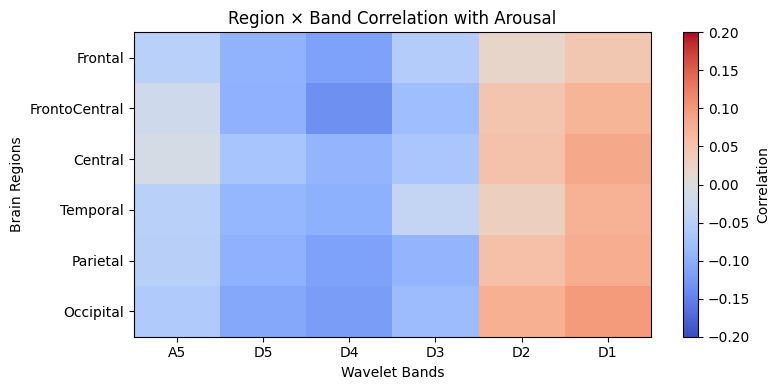

In [19]:
# ---- Arousal heatmap ----
plt.figure(figsize=(8, 4))
plt.imshow(aro_mat, aspect="auto", cmap="coolwarm", vmin=-0.2, vmax=0.2)
plt.colorbar(label="Correlation")
plt.xticks(range(len(bands)), bands)
plt.yticks(range(len(regions)), regions)
plt.title("Region × Band Correlation with Arousal")
plt.xlabel("Wavelet Bands")
plt.ylabel("Brain Regions")
plt.tight_layout()
plt.show()

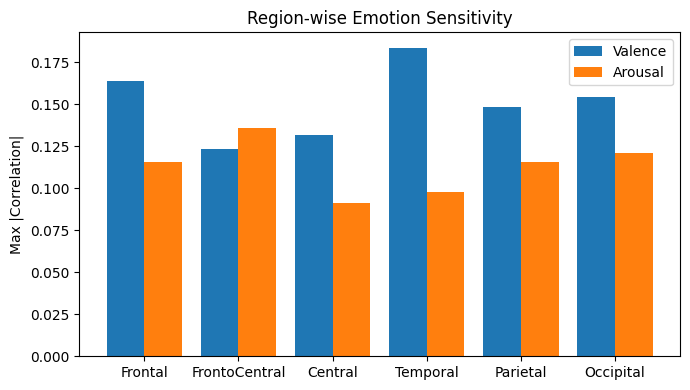

In [20]:
val_strength = np.nanmax(np.abs(val_mat), axis=1)
aro_strength = np.nanmax(np.abs(aro_mat), axis=1)

x = np.arange(len(regions))

plt.figure(figsize=(7,4))
plt.bar(x - 0.2, val_strength, width=0.4, label="Valence")
plt.bar(x + 0.2, aro_strength, width=0.4, label="Arousal")
plt.xticks(x, regions)
plt.ylabel("Max |Correlation|")
plt.title("Region-wise Emotion Sensitivity")
plt.legend()
plt.tight_layout()
plt.show()


**Observations from Region Wise Analysis:**


The region-wise analysis reveals clear differences in how valence and arousal are represented across brain regions and wavelet frequency bands.

For **valence**, the strongest correlations are consistently observed in the D3 sub-band across all regions, with the **temporal region exhibiting the highest sensitivity, followed by frontal, occipital, and parietal regions**. Lower-frequency components, particularly the approximation band A5, show weak or negative correlations across regions, indicating limited relevance of very slow EEG activity for valence estimation.

In contrast, arousal demonstrates a different spectral and spatial pattern. Higher-frequency sub-bands (D2 and D1) show consistently **positive correlations across all regions**, while lower and mid-frequency bands (A5–D4) exhibit weak or negative associations. Unlike valence, arousal-related correlations are more uniformly distributed across regions, suggesting **a less region-specific and more global neural activation pattern**.

Overall, these findings indicate that **valence is characterized by region-dependent, mid-frequency EEG activity**, whereas **arousal is associated with widespread, higher-frequency EEG dynamics**. This region-wise aggregation complements the channel-wise results and provides a structured spatial interpretation of emotion-related EEG responses.


**Band Wise Analysis**



Band-wise analysis was performed to **isolate the contribution of individual wavelet sub-bands (A5–D1) to emotional dimensions** by averaging correlation values across all channels and regions. This analysis focuses exclusively on the frequency-dependent behavior of EEG signals, **independent of spatial variations**.

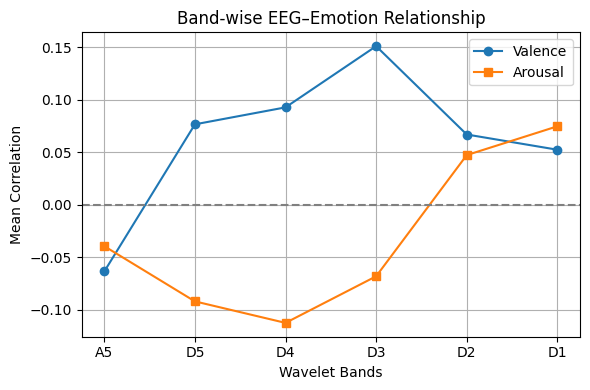

In [21]:
mean_val = np.nanmean(val_mat, axis=0)
mean_aro = np.nanmean(aro_mat, axis=0)

plt.figure(figsize=(6,4))
plt.plot(bands, mean_val, marker="o", label="Valence")
plt.plot(bands, mean_aro, marker="s", label="Arousal")
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Mean Correlation")
plt.xlabel("Wavelet Bands")
plt.title("Band-wise EEG–Emotion Relationship")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Observations from Bands-wise Analysis:**

The band-wise results reveal distinct spectral characteristics for valence and arousal.

**Valence** shows a clear peak in the D3 sub-band, indicating that mid-frequency EEG components contribute most strongly to valence discrimination. Moderate positive correlations are also observed in D4 and D5, while the lowest-frequency approximation band (A5) exhibits weak or negative correlations, suggesting limited relevance of slow EEG activity.

In contrast, **arousal** demonstrates a gradual increase in correlation strength toward higher-frequency bands, with the strongest associations observed in D2 and D1. Lower and mid-frequency bands (A5–D4) consistently show negative or weak correlations, highlighting that arousal-related neural activity is more strongly reflected in faster EEG oscillations.

Importantly, this band-wise analysis provides a frequency-centric perspective that complements the channel-wise and region-wise analyses, confirming that valence and arousal are encoded in different EEG frequency ranges rather than uniformly across the spectrum.

**Subject-wise Consistency Analysis**



*Emotional responses are inherently subjective and can vary significantly across individuals.*

Subject-wise analysis is therefore performed to **assess inter-subject variability** and to verify that the observed EEG–emotion relationships are not driven by a small subset of participants.



**Subject-wise correlations were computed for valence using the D3 wavelet sub-band**, which was identified as the **most informative frequency band in prior band-wise and region-wise analyses**. The temporal region was selected as a representative case to assess consistency of valence-related EEG activity across subjects.

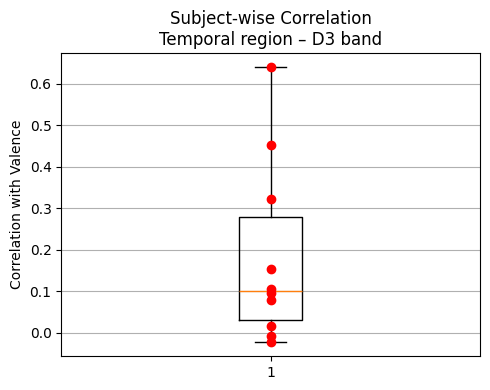

Subject-wise correlations: [ 0.15452088  0.01562488  0.32122527 -0.02290426  0.09641558  0.08042447
  0.45162224 -0.00648202  0.640231    0.10492564]
Mean ± std: 0.18356036735003461 ± 0.20774043270912854


In [22]:
import matplotlib.pyplot as plt
import numpy as np


REGION = "Temporal"
BAND_NAME = "D3"   # choose one key band
BAND_IDX = band_labels.index(BAND_NAME)

# Extract subject-wise correlations (Valence example)
# We recompute subject-wise values from region_feat
# (region_corr_aro stored mean±std, so we recompute directly)

region_idxs = REGION_IDXS[REGION]
region_feat = feat_energy[:, :, region_idxs, :].mean(axis=2)

subject_corrs = []

for s in range(n_subj):
    c = safe_corr(region_feat[s, :, BAND_IDX], valence_all[s, :])
    subject_corrs.append(c)

subject_corrs = np.array(subject_corrs)

# Boxplot
plt.figure(figsize=(5,4))
plt.boxplot(subject_corrs, vert=True)
plt.scatter(np.ones_like(subject_corrs), subject_corrs, color="red", zorder=3)

plt.ylabel("Correlation with Valence")
plt.title(f"Subject-wise Correlation\n{REGION} region – {BAND_NAME} band")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

print("Subject-wise correlations:", subject_corrs)
print("Mean ± std:", np.nanmean(subject_corrs), "±", np.nanstd(subject_corrs))


**Observations from Subject-wise Analysis**

The subject-wise correlation distribution shows a predominantly positive relationship between temporal D3-band EEG features and valence, with **moderate inter-subject variability**. While individual differences are evident, the majority of subjects exhibit positive correlations, indicating a **consistent group-level association** rather than an effect driven by a single subject.

**Conclusion:**

This study presented an exploratory analysis of EEG signals from the DEAP dataset using Discrete Wavelet Transform to investigate neural correlates of emotional valence and arousal. By decomposing EEG signals into multiple wavelet sub-bands, the analysis successfully **captured frequency-specific and spatially distributed emotional patterns** that are not readily observable in the time domain. The results demonstrated that valence-related information is predominantly associated with mid-frequency wavelet sub-bands, while arousal exhibited stronger sensitivity in higher-frequency bands. Subject-wise analysis further revealed notable inter-individual variability, highlighting the **inherently subjective nature of emotional EEG responses**.

The findings of this exploratory study are broadly **consistent with prior EEG-based emotion analysis research** using the DEAP dataset and wavelet-based methods, which similarly report low- to mid-frequency EEG components as informative for valence and higher-frequency activity for arousal. These consistencies reinforce the suitability of discrete wavelet-based multi-resolution analysis for emotion-related EEG studies. However, the limited number of subjects and the exploratory scope of the analysis **restrict the ability to draw strong population-level statistical conclusions**. Future work will focus on incorporating subject-adaptive features and larger datasets to enable more robust modeling and potential emotion classification applications.